# Actor-Critic 방법으로 CartPole의 문제 풀기

[TensorFlow 공식 튜토리얼](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic)을 참고했습니다.

## 설정

In [ ]:
!pip install -q gym

In [ ]:
%%bash
# 시각화를 위한 추가 패키지 설치
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1  # 리눅스 GUI 관련 패키지
pip install -q pyvirtualdisplay > /dev/null 2>&1  # 가상 디스플레이
pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1  # 이미지 표시

In [ ]:
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm

import matplotlib.pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

In [ ]:
# 환경 E
env = gym.make('CartPole-v0')

# 랜덤 시드 설정
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# 나눗셈 연산 안정화를 위한 작은 엡실론 값
eps = np.finfo(np.float32).eps.item()

## 모델

In [ ]:
class ActorCritic(tf.keras.Model):
    """융합된 actor-critic 네트워크."""
    def __init__(
            self,
            num_actions: int,
            num_hidden_units: int):
        """초기화."""
        super().__init__()

        self.common = layers.Dense(num_hidden_units, activation='relu')
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

In [ ]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## 훈련

### 1. 훈련 데이터 수집하기

In [ ]:
# OpenAI Gym의 `env.step` 호출을 TensorFlow 함수의 연산으로 감싸기
# 호출 가능한 TensorFlow 그래프에 포함될 수 있게 함.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """행동에 대해 상태, 보상, done 플래그를 반환."""

    state, reward, done, _ = env.step(action)  # R = E[R_t+1|S_t=s, A_t=a]
    return (state.astype(np.float32),
            np.array(reward, np.int32),
            np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action],
                             [tf.float32, tf.int32, tf.int32])

In [ ]:
def run_episode(
        initial_state: tf.Tensor,
        model: tf.keras.Model,
        max_steps: int) -> List[tf.Tensor]:
    """데이터를 모으기 위해 한 에피소드를 진행."""

    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state

    # 타임스텝 t
    for t in tf.range(max_steps):
        # 상태를 배치가 있는 텐서로 변환 (배치 크기 = 1)
        state = tf.expand_dims(state, 0)  # S_t

        # 모델을 실행하고 행동 확률과 비평 값 받아오기
        action_logits_t, value = model(state)

        # 행동 확률 분포애서 다음 행동을 샘플
        action = tf.random.categorical(action_logits_t, 1)[0, 0]  # A_t
        action_probs_t = tf.nn.softmax(action_logits_t)

        # 비평 값을 저장
        values = values.write(t, tf.squeeze(value))  # V(s)
        # 선택한 행동의 로그 확률 값을 저장
        action_probs = action_probs.write(t, action_probs_t[0, action])

        # 다음 상태와 보상을 얻기 위해 환경에 행동을 적용
        state, reward, done = tf_env_step(action)  # S_t+1, R_t+1
        state.set_shape(initial_state_shape)

        # 보상을 저장
        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    # tf.TensorArray -> tf.Tensor
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()

    return action_probs, values, rewards

### 2. 예상 이익 계산하기

In [ ]:
def get_expected_return(
        rewards: tf.Tensor,
        gamma: float,
        standardize: bool = True) -> tf.Tensor:
    """각 타임 스템에서 예상 이익을 계산."""

    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # `rewards`의 끝에서 시작
    # 보상의 합을 `returns` 배열에 누적
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma*discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns-tf.math.reduce_mean(returns)) /
                   (tf.math.reduce_std(returns)+eps))
        
    return returns

### 3. Actor-Critic 손실

In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
        action_probs: tf.Tensor,
        values: tf.Tensor,
        returns: tf.Tensor) -> tf.Tensor:
    """혼합된 actor-critic 손실을 계산."""

    advantage = returns - values

    action_log_probs = tf.math.log(action_probs)
    actor_loss = (-1) * tf.math.reduce_sum(action_log_probs * advantage)  # L_actor

    critic_loss = huber_loss(values, returns)  # L_critic

    return actor_loss + critic_loss  # L = L_actor + L_critic

### 4. 매개변수를 업데이트하기 위한 훈련 단계 정의하기

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
        initial_state: tf.Tensor,
        model: tf.keras.Model,
        optimizer: tf.keras.optimizers.Optimizer,
        gamma: float,
        max_steps_per_episode: int) -> tf.Tensor:
    """모델 학습 스텝을 실행."""

    with tf.GradientTape() as tape:
        # 한 에피소드 동안 모델을 실행해 학습 데이터 모으기
        action_probs, values, rewards = run_episode(
            initial_state, model, max_steps_per_episode)
        
        # 예상된 반환값 계산
        returns = get_expected_return(rewards, gamma)

        # 학습 데이터를 적절한 TF 텐서 모양으로 변환
        action_probs, values, returns = [
            tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

        # 네트워크를 업데이트하기 위해 손실 값 계산
        loss = compute_loss(action_probs, values, returns)

    # 손실에서 그래디언트 값을 계산
    grads = tape.gradient(loss, model.trainable_variables)

    # 모델의 파라미터에 그래디언트를 적용
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward

### 5. 훈련 루프 실행하기

In [ ]:
%%time

max_episodes = 10000
max_steps_per_episode = 1000

# 100번의 연속적인 시도의 평균 보상 >= 195일 때
# Cartpole-v0는 해결되었다고 판단
reward_threshold = 195
running_reward = 0

# 미래의 보상을 위한 감가율
gamma = 0.99

with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(train_step(
            initial_state, model, optimizer, gamma, max_steps_per_episode))
        
        running_reward = episode_reward*0.01 + running_reward*0.99
        t.set_description(f'Episode {i}')
        t.set_postfix(
            episode_reward=episode_reward, running_reward=running_reward)
        
        # 10개의 에피소드마다 평균 에피소드 보상 표시
        if i%10 == 0:
            pass  # print(f'Episode {i}: average reward: {avg_reward}')

        if running_reward > reward_threshold:
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 708:   7%|▋         | 708/10000 [01:04<14:08, 10.96it/s, episode_reward=200, running_reward=195]


Solved at episode 708: average reward: 195.05!
CPU times: user 1min 29s, sys: 5.27 s, total: 1min 35s
Wall time: 1min 4s


## 시각화

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


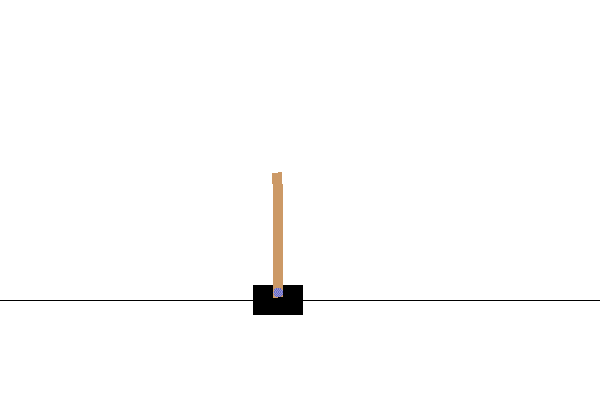

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)